<a href="https://colab.research.google.com/github/martin-fabbri/colab-notebooks/blob/master/tpu/fine_tune_tpu_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fine-tune Xception TPUs (Colab)&nbsp;<img valign="middle" src="https://raw.githubusercontent.com/GoogleCloudPlatform/tensorflow-without-a-phd/master/tensorflow-rl-pong/images/tpu-hexagon.png" width="50">

### Enabling and testing the TPU

In [1]:
import re
import numpy as np
import tensorflow as tf

from matplotlib import pyplot as plt

tf.__version__

'2.3.0'

In [2]:
#@title Enable TPU
use_tpu = True #@param ["False", "True"] {type:"raw"}

if use_tpu:
  try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    tpu_spec = tpu.cluster_spec().as_dict()['worker']
    print('Running on TPU:', tpu_spec)
  except ValueError:
    print('ERROR: Not connected to a TPU.')

  tf.config.experimental_connect_to_cluster(tpu)
  tf.tpu.experimental.initialize_tpu_system(tpu)
  tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)

Running on TPU: ['10.27.206.210:8470']
INFO:tensorflow:Initializing the TPU system: grpc://10.27.206.210:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.27.206.210:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)



## Input data

Our input data is stored on Google Cloud Storage. To more fully use the parallelism TPUs offer us, and to avoid bottlenecking on data transfer, we've stored our input data in TFRecord files, 230 images per file.

Below, we make heavy use of `tf.data.experimental.AUTOTUNE` to optimize different parts of input loading.

All of these techniques are a bit overkill for our (small) dataset, but demonstrate best practices for using TPUs.

In [33]:
AUTO = tf.data.experimental.AUTOTUNE
IMAGE_SIZE = [331, 331]
GCS_PATTERN = 'gs://flowers-public/tfrecords-jpeg-331x331/*.tfrec'
VALIDATION_SPLIT = 0.19
BATCH_SIZE = 16 * tpu_strategy.num_replicas_in_sync
SHUFFLE = 2048
EPOCHS = 12
print('Batch Size:', BATCH_SIZE)

Batch Size: 128


In [4]:
filenames = tf.io.gfile.glob(GCS_PATTERN)
split = len(filenames) - int(len(filenames) * VALIDATION_SPLIT)
TRAIN_FNS = filenames[:split]
VALIDATION_FNS = filenames[split:]
print('Train len:', len(TRAIN_FNS), ' ', 'Validation len:', len(VALIDATION_FNS))

Train len: 13   Validation len: 3


In [5]:
tf.io.FixedLenFeature([], tf.string)

FixedLenFeature(shape=[], dtype=tf.string, default_value=None)

In [6]:
def parse_tfrecord(example):
  features = {
    'image': tf.io.FixedLenFeature([], tf.string), # tf.string means bytestring
    'class': tf.io.FixedLenFeature([], tf.int64),  # shape [] means scalar
    'one_hot_class': tf.io.VarLenFeature(tf.float32),
  }
  example =tf.io.parse_single_example(example, features)
  decoded =tf.image.decode_jpeg(example['image'], channels=3)
  normalized = tf.cast(decoded, tf.float32) / 255.0
  image_tensor = tf.reshape(normalized, [*IMAGE_SIZE, 3])
  one_hot_class = tf.reshape(tf.sparse.to_dense(example['one_hot_class']), [5])
  return image_tensor, one_hot_class

In [7]:
def load_dataset(filenames):
  # Read from TFRecords. For optimal performance, 
  # we interleave reads from multiple files.
  records = tf.data.TFRecordDataset(
      filenames, 
      num_parallel_reads=AUTO
  )
  return records.map(parse_tfrecord, num_parallel_calls=AUTO)

In [8]:
# create some additional training images by randomly flipping and
# increasing/decreasing the saturation of images in the training set
def data_augment(image, one_hot_class):
  modified = tf.image.random_flip_left_right(image)
  modified = tf.image.random_saturation(modified, 0, 2)
  return modified, one_hot_class

In [9]:
def optimize_batch(tfds):
  return tfds.batch(BATCH_SIZE).prefetch(AUTO)

In [10]:
def get_training_dataset():
  dataset = load_dataset(TRAIN_FNS)
  augmented = dataset.map(data_augment, num_parallel_calls=AUTO)
  return optimize_batch(augmented.repeat().shuffle(SHUFFLE))

In [11]:
training_dataset = get_training_dataset()
validation_dataset = optimize_batch(load_dataset(VALIDATION_FNS))

Let's take a peek at the training dataset we've created:

In [16]:
CLASSES = ['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']

def display_one_flower(image, title, subplot, color):
  plt.subplot(subplot)
  plt.axis('off')
  plt.imshow(image)
  plt.title(title, fontsize=16, color=color)

def display_nine_flowers(images, titles, title_colors=None):
  subplot = 331
  plt.figure(figsize=(13,13))
  for i in range(9):
    color = 'black' if title_colors is None else title_colors[i]
    display_one_flower(images[i], titles[i], 331+i, color)
  plt.tight_layout()
  plt.subplots_adjust(wspace=0.1, hspace=0.1)
  plt.show()

def get_dataset_iterator(dataset, n_examples):
  return dataset.unbatch().batch(n_examples).as_numpy_iterator()

training_viz_iterator = get_dataset_iterator(training_dataset, 9)

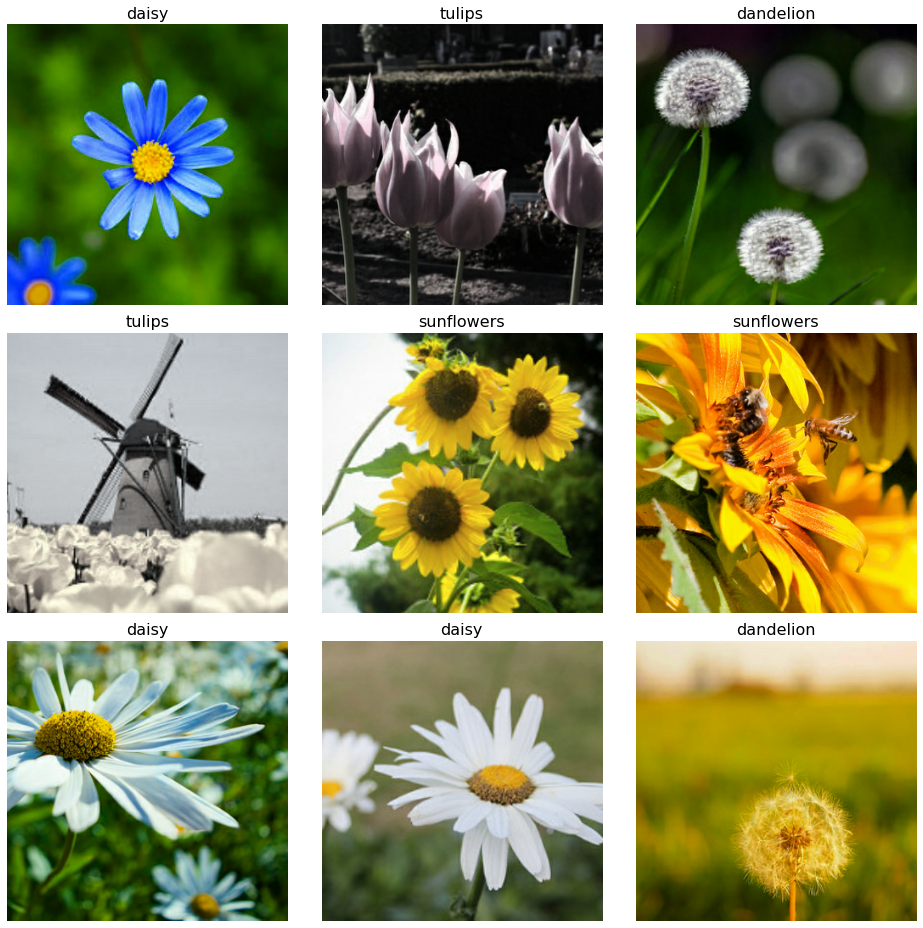

In [18]:
# re-run this cell to show a new batch of images
images, classes = next(training_viz_iterator)
class_idxs = np.argmax(classes, axis=-1)
labels = [CLASSES[idx] for idx in class_idxs]
display_nine_flowers(images, labels)

In [19]:
classes[0]

array([1., 0., 0., 0., 0.], dtype=float32)

### Model

To get maxmimum accuracy, we leverage a pretrained image recognition model (here, [Xception](http://openaccess.thecvf.com/content_cvpr_2017/papers/Chollet_Xception_Deep_Learning_CVPR_2017_paper.pdf)). We drop the ImageNet-specific top layers (`include_top=false`), and add a max pooling and a softmax layer to predict our 5 classes.

In [21]:
def create_model():
  pretrained_model = tf.keras.applications.Xception(
      input_shape=[*IMAGE_SIZE, 3],
      include_top=False
  )
  pretrained_model.trainable = True
  model = tf.keras.Sequential([
    pretrained_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(5, activation='softmax')
  ])
  model.compile(
      optimizer='adam',
      loss='categorical_crossentropy',
      metrics=['accuracy']
  )
  return model

In [22]:
if use_tpu:
  with tpu_strategy.scope():
    model = create_model()
else:
  model = create_model()
model.summary()

83689472/83683744 [==============================] - 2s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception (Functional)        (None, 11, 11, 2048)      20861480  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 5)                 10245     
Total params: 20,871,725
Trainable params: 20,817,197
Non-trainable params: 54,528
_________________________________________________________________


### Training

Calculate the number of images in each dataset. Rather than actually load the data to do so (expensive), we rely on hints in the filename. This is used to calculate the number of batches per epoch.

In [25]:
def count_data_items(filenames):
  # The number of data items is written in the name of the .tfrec files, 
  # i.e. flowers00-230.tfrec = 230 data items
  n = [int(re.compile(r"-([0-9]*)\.").search(filename).group(1)) 
        for filename in filenames]
  return np.sum(n)

In [30]:
n_train = count_data_items(TRAIN_FNS)
n_valid = count_data_items(VALIDATION_FNS)
train_steps = count_data_items(TRAIN_FNS) // BATCH_SIZE
print('TRAINING IMAGES:', n_train, ', STEPS PER EPOCH:', train_steps)
print('VALIDATION IMAGES: ', n_valid)

TRAINING IMAGES: 2990 , STEPS PER EPOCH: 23
VALIDATION IMAGES:  680


#### Learning Rate

In [34]:
start_lr = 0.00001
min_lr = 0.00001
max_lr = 0.0001
if use_tpu:
  max_lr = 0.00005 * tpu_strategy.num_replicas_in_sync
rampup_epochs = 5
sustain_epochs = 0
exp_decay = 0.8 

In [35]:
def lrfn(epoch):
  if epoch < rampup_epochs:
    return (max_lr - start_lr)/rampup_epochs * epoch + start_lr
  elif epoch < rampup_epochs + sustain_epochs:
    return max_lr
  else:
    return (max_lr - min_lr) * exp_decay**(epoch-rampup_epochs-sustain_epochs) + min_lr

In [36]:
lr_callback = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: lrfn(epoch), verbose=True
)

Learning rate per epoch:


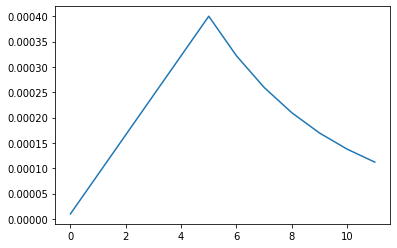

In [37]:
rang = np.arange(EPOCHS)
y = [lrfn(x) for x in rang]
plt.plot(rang, y)
print('Learning rate per epoch:')

Actually train the model. While the first epoch will be quite a bit slower as we must XLA-compile the execution graph and load the data, later epochs should complete in ~7s (training with TPUs).

In [38]:
history = model.fit(
    training_dataset,
    validation_data=validation_dataset,
    steps_per_epoch=train_steps,
    epochs=EPOCHS,
    callbacks=[lr_callback]
)


Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
Epoch 1/12
Instructions for updating:
Use `tf.data.Iterator.get_next_as_optional()` instead.


Instructions for updating:
Use `tf.data.Iterator.get_next_as_optional()` instead.


 2/23 [=>............................] - ETA: 3s - loss: 1.6313 - accuracy: 0.2227WARNING:tensorflow:Callbacks method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0106s vs `on_train_batch_end` time: 0.2933s). Check your callbacks.


23/23 [==============================] - 22s 951ms/step - loss: 1.5079 - accuracy: 0.3743 - val_loss: 1.4405 - val_accuracy: 0.5206

Epoch 00002: LearningRateScheduler reducing learning rate to 8.8e-05.
Epoch 2/12
23/23 [==============================] - 7s 294ms/step - loss: 0.7619 - accuracy: 0.8088 - val_loss: 0.3698 - val_accuracy: 0.8794

Epoch 00003: LearningRateScheduler reducing learning rate to 0.000166.
Epoch 3/12
23/23 [==============================] - 7s 293ms/step - loss: 0.2616 - accuracy: 0.9185 - val_loss: 0.1805 - val_accuracy: 0.9324

Epoch 00004: LearningRateScheduler reducing learning rate to 0.000244.
Epoch 4/12
23/23 [==============================] - 7s 291ms/step - loss: 0.1106 - accuracy: 0.9677 - val_loss: 0.1700 - val_accuracy: 0.9500

Epoch 00005: LearningRateScheduler reducing learning rate to 0.000322.
Epoch 5/12
23/23 [==============================] - 7s 295ms/step - loss: 0.0752 - accuracy: 0.9789 - val_loss: 0.1178 - val_accuracy: 0.9603

Epoch 00006:

In [39]:
final_accuracy = history.history['val_accuracy'][-5:]
print('FINAL ACCURACY MEAN-5: ', np.mean(final_accuracy))

FINAL ACCURACY MEAN-5:  0.9600000143051147


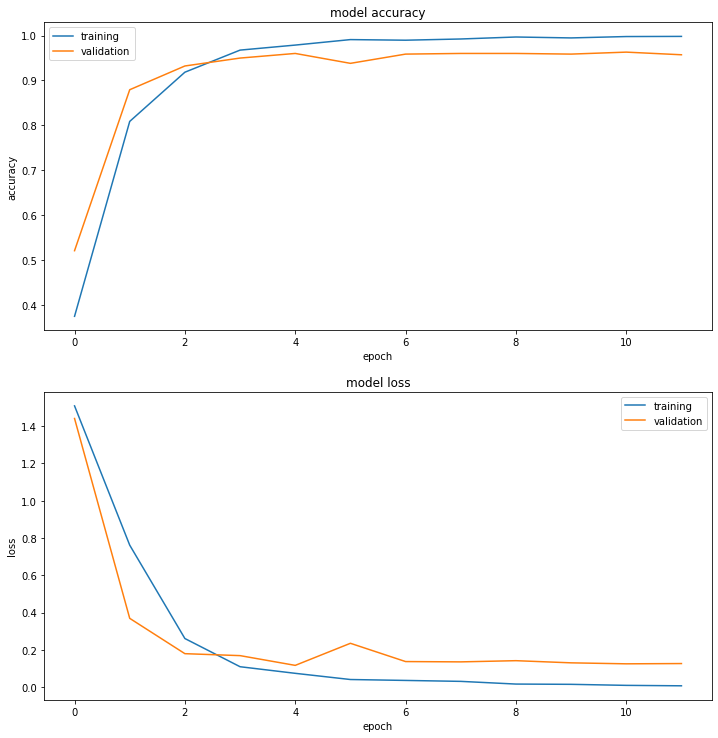

In [40]:
def display_training_curves(training, validation, title, subplot):
  ax = plt.subplot(subplot)
  ax.plot(training)
  ax.plot(validation)
  ax.set_title('model '+ title)
  ax.set_ylabel(title)
  ax.set_xlabel('epoch')
  ax.legend(['training', 'validation'])

plt.subplots(figsize=(10,10))
plt.tight_layout()
display_training_curves(history.history['accuracy'], history.history['val_accuracy'], 'accuracy', 211)
display_training_curves(history.history['loss'], history.history['val_loss'], 'loss', 212)